## Sacramento Redlining

<img src="images/sac-aerial.png" alt="Sacramento Aerial Landscape" width="700" height="600" longdesc="https://www.photopilot.com/blog/downtown-sacramento-california-state-capital" /> 

#### Introduction

During the mid-late 1930s in the United States, redlining maps proliferated and became common practice in lending decisions until the 1968 Fair Housing Act formally banned explicit racial discrimination in mortgage lending (Michney, n.d.). The best preserved maps of that era are the Home Owners' Loan Corporation (HOLC) security maps created through its City Survey from 1935 to 1940. HOLC was established through the New Deal to support homeowners in the decimated housing market. The HOLC Mortgage Rehabilitation Department (MRD) aimed to meet that objective while minimizing an additional bailout of underwater mortgages. Field agents surveyed municipalities with populations over 40,000, 239 cities in total including Sacramento, California, and assembled reports on the health of a city’s real estate market.

HOLC surveys equated the physical characteristics of a built environment with the racial and economic attributes of building residents. Physical deterioration was perceived as a sign of demographic change. The HOLC rating system distinguished neighborhoods by grade and color: A or green areas consisted of new buildings and wealthy, white residents; B or blue areas may have incorporated Jewish residents and were "still desirable"; C or yellow areas were described as in decline; and D or red areas had already "declined" and been deemed hazardous for lending, with even a single Black resident relegating a neighborhood to this grade (Zimring, 2015). These maps enabled HOLC and the Federal Housing Authority to issue insured mortgages to white people living in homogenous developments of new, clean homes. Racial segregation was amplified further in the 20th century with waste handling businesses clustered in non-white residential areas and spatial environmental inequalities emerging by 1960.

#### Data Description

The [HLSL30 v002](doi:10.5067/HLS/HLSL30.002) product provides 30-m Nadir Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat 8/9 Operational Land Imager (OLI) data products through the Harmonized Landsat Sentinel-2 (HLS) project. The sensor resolution is 30 m, imagery resolution is 30 m, and the temporal resolution is daily with an 8 day revisit time. 

The [Sacramento subset](https://dsl.richmond.edu/panorama/redlining/data/CA-Sacramento) of the Mapping Inequality dataset is derived from [City Survey Files, 1935-1940](https://catalog.archives.gov/id/720357) at the National Archives. The data contains redlining maps and reports of economic health and mortgage lending risk by location.

#### Data Citation

Madron, J., Champine, R., Dzuliashvili, Z., Encino, R., Holland, J., Jones, K., … Kliebert, P. (2023). *Mapping inequality: Redlining in New Deal America* (3) [Data set]. University of Richmond. https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg

NASA. (2024). *HLSL30 v002* [Data set]. http://doi.org/10.5067/HLS/HLSL30.002

#### Methods

The [redlining GeoPackage](https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg) was loaded into a GeoDataFrame with [geopandas](https://geopandas.org/) and subset for the city of Sacramento. [earthaccess](https://earthaccess.readthedocs.io/en/latest/) (a library for NASA's Search API) retrieved data granules by dataset (HLSL30) and limited the scope to a single day in 2024 and the spatial bounds collected from the redlining GeoDataFrame. Next the landsat data was filtered by band and stored in a [pandas](https://pandas.pydata.org/docs/reference/index.html) DataFrame. Data granules were grouped by tile ID, subset to red, green, and NIR bands, cropped, scaled, masked, and merged before storing the resulting [xarray](https://docs.xarray.dev/) DataArrays in a dictionary indexed by band.

Normalized Difference Vegetation Index (NDVI) was calculated with band DataArrays. The [regionmask](https://regionmask.readthedocs.io/) library created a mask of the HOLC zones from the redlining GeoDataFrame and the longitude and latitude sourced from a band DataArray. Thereafter, NDVI summary statistics were calculated for each zone using the NDVI DataArray and redlining mask with [xarray-spatial](https://xarray-spatial.readthedocs.io/en/stable/). Statistics were merged on the zone with the redlining GeoDataFrame and the HOLC grades were ordered for plotting. NDVI and redlining grade were plotted in linked subplots using the [hvplot API](https://hvplot.holoviz.org/). A scikit-learn [decision tree](https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html) was then applied to predict HOLC grade by NDVI average and evaluated by *k*-fold cross-validation. Finally, the grade prediction error by zone was determined and plotted.

#### Analysis

Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pathlib
import re 

import numpy as np 
import pandas as pd
import geopandas as gpd 
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Work with raster data
import xarray as xr
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import cartopy.crs as ccrs 
import regionmask
from xrspatial import zonal_stats

import earthaccess

Retrieve Redlining Data

In [2]:
# create the project data directory
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'redlining',
)
os.makedirs(data_dir, exist_ok=True)

In [3]:
# Define url for redlining download
us_census_redlining_url = (
    "https://dsl.richmond.edu/panorama/redlining/static"
    "/mappinginequality.gpkg"
)

# Set up a path to save the data locally
redlining_dir = os.path.join(data_dir, 'redlining')

# Make the U.S. Census Survey directory
os.makedirs(redlining_dir, exist_ok=True)

# Join redlining geopackage path
redlining_map_path = os.path.join(redlining_dir, 'redlining.shp')

# Only download once and create GeoDataFrame
if not os.path.exists(redlining_map_path):
    redlining_gdf = gpd.read_file(us_census_redlining_url)
    redlining_gdf.to_file(redlining_map_path)

# Load from file
redlining_gdf = (
    gpd.read_file(redlining_map_path)
)

In [4]:
# Select city data 
sacramento_redlining_gdf = redlining_gdf.loc[redlining_gdf['city'] == 'Sacramento']

# Drop rows where column 'grade' is None
grade_gdf= sacramento_redlining_gdf.dropna(subset=['grade'])

# dissolve all the geometries within a given group (city) into a single geometric feature
# plot with EsriImagery basemap  
grade_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='HOLC Redlining of Sacramento',
    c="grade", line_color='darkgrey', line_width=3,
    frame_width=550
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (grade)

Process Multispectral Data

In [5]:
earthaccess.login(strategy="interactive", persist=True)

In [6]:
sacramento_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(sacramento_redlining_gdf.total_bounds),
    temporal=("2024-07-11"),
    count=30
)

In [7]:
landsat_data = earthaccess.open(sacramento_results)

QUEUEING TASKS | :   0%|          | 0/285 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/285 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/285 [00:00<?, ?it/s]

In [8]:
def process_image(uri, bounds_gdf):
    """
    Load, crop, and scale a raster image from earthaccess

    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    # load and scale
    da = rxr.open_rasterio(uri, mask_and_scale=True).squeeze()

    # obtain crs from raster
    reflectance_data_crs = da.rio.crs

    # match coordinate reference systems
    bounds_gdf = bounds_gdf.to_crs(reflectance_data_crs)

    # get study bounds da
    study_bounds = bounds_gdf.total_bounds

    # crop
    cropped_da = da.rio.clip_box(
      minx=study_bounds[0], 
      miny=study_bounds[1], 
      maxx=study_bounds[2], 
      maxy=study_bounds[3]
    )

    return cropped_da

In [9]:
def process_cloud_mask(cloud_uri, bits_to_mask):
    """
    Load an 8-bit Fmask file and process to a boolean mask

    Parameters
    ----------
    uri: file-like or path-like
      Fmask file accessor downloaded or obtained from earthaccess
    bits_to_mask: list of int
      The indices of the bits to mask if set

    Returns
    -------
    cloud_mask: np.array
      Cloud mask
    """
    cloud_da = rxr.open_rasterio(cloud_uri, mask_and_scale=True).squeeze()

    # Get the cloud mask as bits
    cloud_bits = (
        np.unpackbits(
            (
                # Get the cloud mask as an array...
                cloud_da.values
                # ... of 8-bit integers
                .astype('uint8')
                # With an extra axis to unpack the bits into
                [:, :, np.newaxis]
            ), 
            # List the least significat bit first to match the user guide
            bitorder='little',
            # Expand the array in a new dimension
            axis=-1)
    )
    
    # Add up the bits for each pixel
    cloud_mask = np.sum(
        # Select bits 
        cloud_bits[:,:,bits_to_mask], 
        # Sum along the bit axis
        axis=-1
    )

    # Mask the pixel if the sum is greater than 0
    # (If any of the bits are True)
    cloud_mask = cloud_mask == 0

    return cloud_mask

In [10]:
# Compile a regular expression to search for metadata
# Use () to select the desired name and only output that name
uri_re = re.compile(
    r"v2.0/(HLS.L30.*.tif)"
)
# Select unique granules
tile_id_re = re.compile(
    r"HLSL30.020/(HLS.L30..*.v2.0)/HLS"
)
# Grab band IDs
band_id_re = re.compile(
    r"HLS.L30..*v2.0.(\D{1}.*).tif"
)

# Find all the metadata in the file name 
uri_groups = []

for idx, uri in enumerate(landsat_data):
    # Make sure uri has full_name property first
    if (hasattr(uri, 'full_name')):
        file_name = uri_re.findall(uri.full_name)[0]
        tile_id = tile_id_re.findall(uri.full_name)[0]
        band_id = band_id_re.findall(uri.full_name)[0]

        uri_groups.append({
            'filename': file_name,
            'tile_id': tile_id,
            'band_id': band_id,
            'uri': uri
        })

# Create a DataFrame with the File-like URI
raster_df = pd.DataFrame(data=uri_groups, columns=['filename', 'tile_id', 'band_id', 'uri'])

# Only keep spectral bands and cloud Fmask
exclude_files = ['VAA', 'VZA', 'SAA', 'SZA']
# Select data not in the excluded files list
raster_df = raster_df[~raster_df['band_id'].isin(exclude_files)]

# Check the results
raster_df

,filename,tile_id,band_id,uri
0,HLS.L30.T10SFH.2024193T184504.v2.0.B04.tif,HLS.L30.T10SFH.2024193T184504.v2.0,B04,"<File-like object HTTPFileSystem, https://data..."
1,HLS.L30.T10SFH.2024193T184504.v2.0.B03.tif,HLS.L30.T10SFH.2024193T184504.v2.0,B03,"<File-like object HTTPFileSystem, https://data..."
2,HLS.L30.T10SFH.2024193T184504.v2.0.B06.tif,HLS.L30.T10SFH.2024193T184504.v2.0,B06,"<File-like object HTTPFileSystem, https://data..."
3,HLS.L30.T10SFH.2024193T184504.v2.0.Fmask.tif,HLS.L30.T10SFH.2024193T184504.v2.0,Fmask,"<File-like object HTTPFileSystem, https://data..."
7,HLS.L30.T10SFH.2024193T184504.v2.0.B07.tif,HLS.L30.T10SFH.2024193T184504.v2.0,B07,"<File-like object HTTPFileSystem, https://data..."
...,...,...,...,...
279,HLS.L30.T10SFH.2024337T184554.v2.0.B01.tif,HLS.L30.T10SFH.2024337T184554.v2.0,B01,"<File-like object HTTPFileSystem, https://data..."
280,HLS.L30.T10SFH.2024337T184554.v2.0.B09.tif,HLS.L30.T10SFH.2024337T184554.v2.0,B09,"<File-like object HTTPFileSystem, https://data..."
282,HLS.L30.T10SFH.2024337T184554.v2.0.Fmask.tif,HLS.L30.T10SFH.2024337T184554.v2.0,Fmask,"<File-like object HTTPFileSystem, https://data..."
283,HLS.L30.T10SFH.2024337T184554.v2.0.B07.tif,HLS.L30.T10SFH.2024337T184554.v2.0,B07,"<File-like object HTTPFileSystem, https://data..."


In [12]:
# Bands of interest
bands = {
    'B02': 'red',
    'B03': 'green',
    'B05': 'nir'
}
bits_to_mask = [
    1, # Cloud
    2, # Adjacent to cloud
    3, # Cloud shadow
    5  # Water (to not confuse with greenspace)
]
# Initialize structure for saving images
sac_das = {band_name: [] for band_name in bands.keys()}

# unique data granules
tile_groups = raster_df.groupby('tile_id')

for tile_name, tile_df in tile_groups:
    # Grab Fmask row from tile group
    Fmask_row = tile_df.loc[tile_df['band_id'] == 'Fmask']
    # Load the cloud mask
    cloud_path = Fmask_row.uri.values[0]
    cloud_mask = process_cloud_mask(cloud_path, bits_to_mask)

    # Load spectral bands
    keep_bands = ['B03', 'B02', 'B05']
    selected_bands_df = tile_df[tile_df['band_id'].isin(keep_bands)]
    band_groups = selected_bands_df.groupby('band_id')

    for band_name, band_df in band_groups:
        for index, row in band_df.iterrows():
            # Process band
            cropped_da = process_image(row.uri, sacramento_redlining_gdf)

            # Apply mask on band to remove unwanted cloud data
            cloud_masked_da = cropped_da.where(~cropped_da.isin(cloud_mask))

            # Store the resulting DataArray
            sac_das[band_name].append(cloud_masked_da)

sac_das

{'B02': [<xarray.DataArray (y: 337, x: 281)> Size: 379kB
  array([[0.0406    , 0.0452    , 0.055     , ..., 0.09339999, 0.0823    ,
          0.0734    ],
         [0.0383    , 0.0641    , 0.11279999, ..., 0.1027    , 0.0919    ,
          0.088     ],
         [0.0416    , 0.0602    , 0.1178    , ..., 0.1076    , 0.0922    ,
          0.0826    ],
         ...,
         [0.0572    , 0.0708    , 0.1027    , ..., 0.1125    , 0.09119999,
          0.0829    ],
         [0.0671    , 0.0506    , 0.07889999, ..., 0.0954    , 0.08419999,
          0.0699    ],
         [0.075     , 0.047     , 0.0635    , ..., 0.0931    , 0.0783    ,
          0.0642    ]], dtype=float32)
  Coordinates:
      band         int64 8B 1
    * x            (x) float64 2kB 6.29e+05 6.29e+05 ... 6.374e+05 6.374e+05
    * y            (y) float64 3kB 4.276e+06 4.276e+06 ... 4.266e+06 4.266e+06
      spatial_ref  int64 8B 0
  Attributes: (12/33)
      ACCODE:                    Lasrc; Lasrc
      arop_ave_xshift(mete

In [13]:
sac_das_merged = {}

# Merge all tiles
for band_name, das in sac_das.items():
    merged = merge_arrays(das)
    sac_das_merged[band_name] = merged

Inspect Reflectance

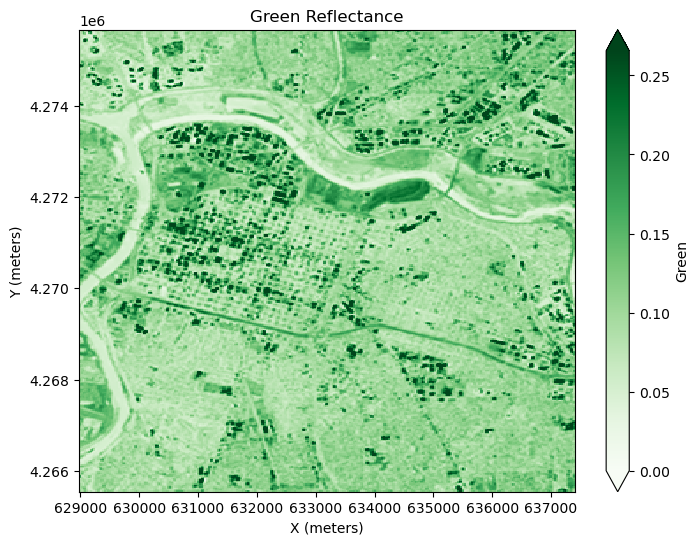

In [14]:
fig = plt.figure(figsize=(8, 6)) 
ax = plt.axes()

city_green_plt = sac_das_merged['B03'].plot(cmap='Greens', vmin=0, robust=True, cbar_kwargs={'label': 'Green'})

plt.title('Green Reflectance')
# based on the CRS projection 
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')

fig.savefig("images/city-green-reflectance.png") 

city_green_plt

Explore relationship between Normalized Difference Vegetation Index and HOLC grades

In [15]:
# Calculate Normalized Difference Vegetation Index (NDVI)

sac_ndvi = (
    (sac_das_merged['B05'].values - sac_das_merged['B02'].values)
    / (sac_das_merged['B05'].values + sac_das_merged['B02'].values)
)

coords= {
    'latitude': sac_das_merged['B02'].coords['y'].values,
    'longitude': sac_das_merged['B02'].coords['x'].values
}

sac_ndvi_da = xr.DataArray(sac_ndvi, coords)

sac_ndvi_da

<xarray.DataArray (latitude: 337, longitude: 281)> Size: 379kB
array([[0.66515464, 0.6360708 , 0.611856  , ..., 0.52077985, 0.5774069 ,
        0.63226455],
       [0.6786913 , 0.5528427 , 0.37071133, ..., 0.42769572, 0.46909305,
        0.5018398 ],
       [0.710508  , 0.5537435 , 0.31808972, ..., 0.48676363, 0.49672487,
        0.49954557],
       ...,
       [0.695096  , 0.64314514, 0.50302446, ..., 0.551167  , 0.6259996 ,
        0.63277966],
       [0.6399249 , 0.71200913, 0.5165441 , ..., 0.57917947, 0.6294014 ,
        0.6542171 ],
       [0.5460049 , 0.70468116, 0.5291064 , ..., 0.52608806, 0.64189345,
        0.6652762 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 3kB 4.276e+06 4.276e+06 ... 4.266e+06
  * longitude  (longitude) float64 2kB 6.29e+05 6.29e+05 ... 6.374e+05 6.374e+05

In [16]:
# Obtain mask for zones
sac_redlining_mask = regionmask.mask_geopandas(
    sacramento_redlining_gdf.to_crs(sac_das_merged['B02'].rio.crs), 
    sac_das_merged['B02'].x, # meters
    sac_das_merged['B02'].y, # meters 
    # The regions do not overlap bc no lat/long coords
    overlap=False,
    # We're not using geographic coordinates
    wrap_lon=False
)

In [17]:
# Calculate NDVI stats for each redlining zone

sac_ndvi_stats = zonal_stats(zones=sac_redlining_mask, values=sac_ndvi_da)

sac_ndvi_stats.head()

,zone,mean,max,min,sum,std,var,count
0,778.0,0.575614,0.726265,0.423022,156.567139,0.057787,0.003339,272.0
1,779.0,0.609547,0.854545,0.243418,911.273315,0.071055,0.005049,1495.0
2,780.0,0.630168,0.784928,0.427215,204.174347,0.068254,0.004659,324.0
3,781.0,0.577931,0.820706,0.268857,162.398499,0.095267,0.009076,281.0
4,782.0,0.619878,0.797546,0.170208,275.845490,0.096845,0.009379,445.0


In [18]:
# Merge stats on the zone 

# zone is on the index
sacramento_redlining_gdf.index

Index([778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791,
       792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805,
       806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819,
       820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833,
       834, 835],
      dtype='int64')

In [19]:
# Merge the NDVI stats with redlining geometry into one `GeoDataFrame` on zone index
sac_ndvi_gdf = sacramento_redlining_gdf.merge(sac_ndvi_stats.set_index('zone'), left_index=True, right_index=True)

# Change grade to ordered Categorical for plotting
sac_ndvi_gdf.grade = pd.Categorical(
    sac_ndvi_gdf.grade,
    ordered=True, # the grades are ordered
    categories=['A', 'B', 'C', 'D']
)

# Drop rows with NA grades
sac_ndvi_gdf = sac_ndvi_gdf.dropna(subset=["grade"])

In [20]:
# Plot NDVI and redlining grade in linked subplots
(
    sac_ndvi_gdf.hvplot(
        title='NDVI',
        c='mean',
        geo=True,
        cmap='Greens',
        frame_width=300,
        frame_height=400
    )
    +
    sac_ndvi_gdf.hvplot(
        title='HOLC Grades',
        c='grade',
        geo=True,
        cmap='cet_rainbow4',
        frame_width=300,
        frame_height=400
    )
)

:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (mean)
   .Polygons.II :Polygons   [Longitude,Latitude]   (grade)

In [21]:
# Convert categories to numbers
sac_ndvi_gdf['grade_codes'] = sac_ndvi_gdf.grade.cat.codes

# Fit model
tree_classifier = DecisionTreeClassifier(max_depth=2).fit(
    sac_ndvi_gdf[['mean']], # predict with ndvi mean
    sac_ndvi_gdf['grade_codes'] # observed target
)

In [22]:
# Plot results

sac_ndvi_gdf['predictions'] = (
    tree_classifier.predict(sac_ndvi_gdf[['mean']])
)

sac_ndvi_gdf['error'] = (
    sac_ndvi_gdf['predictions'] -
    sac_ndvi_gdf['grade_codes']
)

sac_ndvi_gdf.hvplot(
    title='Grade Prediction Error',
    c='error',
    geo=True,
    frame_width=400,
    frame_height=500
)

:Polygons   [Longitude,Latitude]   (error)

In [25]:
# Evaluate the model with cross-validation

results = cross_val_score(
    DecisionTreeClassifier(max_depth=2),
    sac_ndvi_gdf[['mean']],
    sac_ndvi_gdf['grade_codes'],
    cv=4 # reduce folds because of small dataset
)

print(f'Results: {results}')

Results: [0.57142857 0.42857143 0.64285714 0.42857143]


#### Discussion

The legacy of redlining has siloed communities of color in areas that are more likely to lack green space and be located closer to environmental hazards (Thomas, 2022). The observed environmental injustices imposed in redlined neighborhoods are extensive with impacts ranging across communities: 

- Today, approximately 43% of Black Americans live in urban “heat islands” which contain minimal tree cover and large amounts of exposed asphalt and concrete which retain heat and increase ambient temperature. These neighborhoods are up to 12.6°F warmer than non-redlined neighborhoods. Extreme heat events are also exacerbated in redlined areas, with Black Americans incurring higher rates of heat-related deaths and illnesses than white communities.
- Compared to Latinx Americans, white communities are 21% less likely to live in a heat island. Additionally, over 4.3 million Latinx families live in homes without access to air-conditioning. Air pollution is another great concern: about 50% of Latinx individuals live in areas which violate clean air and ozone standards.
- Urban heat islands magnify impacts of diminished indoor air quality as well which has been attributed to asthma rates in tribal communities that are nearly double the U.S. average. Furthermore, the inequitable distribution of urban green space coincides with other forms of systemic racism and their impacts, such as government displacement of tribal communities and sparse access to safe running water.
- On average, 50% of Asian American communities have reduced access to shaded green spaces and 32% of Asian Americans live in neighborhoods where heat-retaining surfaces cover more than half of the ground. Moreover, Southeast and South Asian communities have the 4th and 5th highest risk of cancer due to air pollution. Compared to other racial groups, Chinese and Korean Americans have the largest mean cancer risk from air pollution exposure.

Robert Bullard, the "father of environmental justice" in the United States, asserted in a 2018 [interview](https://www.theguardian.com/commentisfree/2018/dec/20/robert-bullard-interview-environmental-justice-civil-rights-movement) that inequity in neighborhoods is not just about proximity to hazards, but also limited access to elements that foster healthy communities: "Communities of color don’t get a fair share of the good stuff – parks, green spaces, nature trails, good schools, farmers markets, good stores. They get less of all the things that make communities healthy and get more of their fair share of the bad stuff." This is phenomenon is reflected in the HOLC area descriptions. The [HOLC security map](https://dsl.richmond.edu/panorama/redlining/data/CA-Sacramento) for Sacramento described one "B" area as a "new subdivision, located in a natural oak grove" with homogenous improvements and population, high class construction, and favorable influences encompassing schools, churches, and trading facilities. On the contrary, "D" areas were described as having detrimental influences such as a heterogeneous population and the absence of building improvements.

We can inspect landsat data for the redlining differences in vegetation (see Green Reflectance plot), however there is not a significant decrease in green radiation until a plant is extremely stressed. A more useful indicator of healthy vegetation is the comparison of Near-InfraRed (NIR) to red reflectance, calculated by the Normalized Difference Vegetation Index (NDVI). For each redlining zone, the NDVI was assessed (see NDVI vs. HOLC Grades plot). A simple decision tree classifier performs fairly well in predicting the HOLC grade based on the mean NDVI. Given the 4 target grades and scores rising well above 25% accuracy, this suggests a moderate to mid-high dependency between NDVI and HOLC grade.

#### References

Barrett, A., Battisto, C., J. Bourbeau, J., Fisher, M., Kaufman, D., Kennedy, J., … Steiker, A. (2024). *earthaccess* (Version 0.12.0) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.8365009

Collins, B., Hetzel, J. T., & Metzger, T. C. (2024). *xarray-spatial* (Version 0.4.0) [Computer software]. GitHub. https://github.com/makepath/xarray-spatial/releases/tag/v0.4.0

Harris, C. R., Millman, K. J., J. van der Walt, S., Gommers, R., Virtanen, P., Cournapeau, D., … Oliphant, T. E. (2020). Array programming with NumPy. *Nature, 585*, 357–362. https://doi.org/10.1038/s41586-020-2649-2

Hauser, M., Spring, A., Busecke, J., van Driel, M., & Lorenz, R. (2024). *regionmask/regionmask: version 0.12.1* (Version 0.12.1) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.3585542

Hunter, J. D. (2024). *Matplotlib: A 2D graphics environment* (Version 3.9.2) [Computer software]. Zenodo. https://zenodo.org/records/13308876

Hoyer, S. & Hamman, J., (2017). xarray: N-D labeled arrays and datasets in Python. *Journal of Open Research Software. 5*(1), 10. https://doi.org/10.5334/jors.148

Jordahl, K., Van den Bossche, J., Fleischmann, M., Wasserman, J., McBride, J., Gerard, J., … Leblanc, F. (2024). *geopandas/geopandas: v1.0.1* (Version 1.0.1) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.12625316 

Met Office. (2024). *Cartopy: a cartographic python library with a Matplotlib interface* (Version 0.24.1) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.13905945

Michney, T. M. (n.d.). How and why the Home Owners' Loan Corporation made its redlining maps. Mapping Inequality. https://dsl.richmond.edu/panorama/redlining/howandwhy

Milman, O. (2018, December 20). Robert Bullard: ‘Environmental justice isn’t just slang, it’s real’. The Guardian. https://www.theguardian.com/commentisfree/2018/dec/20/robert-bullard-interview-environmental-justice-civil-rights-movement

Python Software Foundation. (2024). *Python* (Version 3.12.6) [Computer software]. https://docs.python.org/release/3.12.6 

Rudiger, P., Liquet, M., Signell, J., Hansen, S. H., Bednar, J. A., Madsen, M. S., … Hilton, T. W. (2024). *holoviz/hvplot: Version 0.11.0* (Version 0.11.0) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.13851295 

Snow, A. D., Scott, R., Raspaud, M., Brochart, D., Kouzoubov, K., Henderson, S., … Weidenholzer, L. (2024). *corteva/rioxarray: 0.18.1 Release* (Version 0.18.1) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.4570456

The pandas development team. (2024). *pandas-dev/pandas: Pandas* (Version 2.2.2) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.3509134

The scikit-learn developers. (2024). scikit-learn (1.5.2). [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.13749328

Thomas, L. (2022). *The intersectional environmentalist: How to dismantle systems of oppression to protect people + planet*. Little, Brown and Company.

Zimring, C. A. (2015). *Clean and white: A history of environmental racism in the United States.* New York University Press.
